In [1]:
import pandas
import datetime
import numpy
from scipy.optimize import curve_fit
import seaborn as sns
import matplotlib.pyplot as plt
import os
from matplotlib.colors import ListedColormap
from matplotlib import ticker
%matplotlib inline
from matplotlib import rcParams

In [2]:
#### In this block we load Velocity data ####
#### In this block we load Velocity data ####
#### In this block we load Velocity data ####
# file with velocities
rawVelFileName = "../data/test-vels-north.txt"
# need to format the file appropritely, before we can read it
outFormattedFile = "../data/formatted-vels.txt"
# os.system( 'cat ' + rawVelFileName + ' | tr -s "  " > ' + outFormattedFile )
inpColNames = [ "dateStr", "timeStr", "beam", "range", \
          "azim", "Vlos", "MLAT", "MLON", "MLT", "radId", \
          "radCode"]
velsDataDF = pandas.read_csv(outFormattedFile, sep=' ',\
                             header=None, names=inpColNames)
# add a datetime col
velsDataDF["date"] = pandas.to_datetime( \
                        velsDataDF['dateStr'].astype(str) + "-" +\
                        velsDataDF['timeStr'].astype(str), format='%Y%m%d-%H%M')
# for some reason MLAT is a str type, convert it to float
velsDataDF["MLAT"] = velsDataDF["MLAT"].astype(float)
# Also get a normMLT for plotting
velsDataDF['normMLT'] = [x-24 if x >= 12 else x for x in velsDataDF['MLT']]
velsDataDF.head()
#### In this block we load SAPS Velocity data ####
#### In this block we load SAPS Velocity data ####
#### In this block we load SAPS Velocity data ####

,dateStr,timeStr,beam,range,azim,Vlos,MLAT,MLON,MLT,radId,radCode,date,normMLT
0,20110409,600,0,26,-60.95,-2.2716,53.2044,-21.8611,23.6993,33,bks,2011-04-09 06:00:00,-0.3007
1,20110409,600,0,27,-60.95,-5.1056,53.3065,-22.5771,23.6515,33,bks,2011-04-09 06:00:00,-0.3485
2,20110409,600,0,28,-60.95,-5.1056,53.4035,-23.2954,23.6036,33,bks,2011-04-09 06:00:00,-0.3964
3,20110409,600,0,29,-60.95,-4.5666,53.4954,-24.0159,23.5556,33,bks,2011-04-09 06:00:00,-0.4444
4,20110409,600,0,30,-60.95,-3.6944,53.5823,-24.7384,23.5074,33,bks,2011-04-09 06:00:00,-0.4926


In [3]:
#### In this block we filter for SAPS velocities ####
#### In this block we filter for SAPS velocities ####
#### In this block we filter for SAPS velocities ####
# remove velocies whose magnitude is less than 200 m/s
velsDataDF = velsDataDF[ abs(velsDataDF["Vlos"]) >= 200. ]
# SAPS(westward) Vlos are positive for positive azimuths and vice versa.
# filter the others out
velsDataDF = velsDataDF[ velsDataDF["azim"]/velsDataDF["Vlos"] > 0. ].reset_index(drop=True)
velsDataDF.head()
#### In this block we filter for SAPS velocities ####
#### In this block we filter for SAPS velocities ####
#### In this block we filter for SAPS velocities ####

,dateStr,timeStr,beam,range,azim,Vlos,MLAT,MLON,MLT,radId,radCode,date,normMLT
0,20110409,706,9,28,-26.21,-244.3651,59.1492,-14.0168,1.3205,33,bks,2011-04-09 07:06:00,1.3205
1,20110409,706,10,28,-22.35,-244.3651,59.5371,-12.4132,1.4274,33,bks,2011-04-09 07:06:00,1.4274
2,20110409,708,9,27,-26.21,-226.6634,58.8263,-13.5483,1.3848,33,bks,2011-04-09 07:08:00,1.3848
3,20110409,708,10,27,-22.35,-226.6634,59.1965,-12.0037,1.4878,33,bks,2011-04-09 07:08:00,1.4878
4,20110409,730,8,27,-30.07,-257.8685,58.3937,-14.9997,1.6560,33,bks,2011-04-09 07:30:00,1.6560


In [4]:
#### Need prev SAPS data to determine SAPS scatter ####
#### Need prev SAPS data to determine SAPS scatter ####
#### Need prev SAPS data to determine SAPS scatter ####
datFileName = "../data/processedSaps.txt"
sapsDataDF = pandas.read_csv(datFileName, sep=' ', dtype={'dateStr':'str', 'time': 'str'})

sapsDataDF["date"] = pandas.to_datetime( \
                        sapsDataDF['dateStr'] + "-" +\
                        sapsDataDF['time'], format='%Y%m%d-%H%M')
sapsDataDF.head()
#### Need prev SAPS data to determine SAPS scatter ####
#### Need prev SAPS data to determine SAPS scatter ####
#### Need prev SAPS data to determine SAPS scatter ####

,dateStr,sapsLat,sapsMLT,sapsVel,radId,poesLat,poesMLT,dst_date,dst_index,time,date
0,20110107,56.5,17.7543,308.2077,33.0,62.0082,18.0,2011-01-07 00:00:00,-18.0,0000,2011-01-07
1,20110107,55.5,18.0147,224.1588,33.0,62.0082,18.0,2011-01-07 00:00:00,-18.0,0000,2011-01-07
2,20110107,56.5,17.8749,307.4328,33.0,62.0082,18.0,2011-01-07 00:00:00,-18.0,0000,2011-01-07
3,20110107,55.5,18.1324,222.4787,33.0,62.0082,18.0,2011-01-07 00:00:00,-18.0,0000,2011-01-07
4,20110107,56.5,17.9955,305.4201,33.0,62.0082,18.0,2011-01-07 00:00:00,-18.0,0000,2011-01-07


In [5]:
#### Choose a time to and get POES boundaries as well ####
#### Choose a time to and get POES boundaries as well ####
#### Choose a time to and get POES boundaries as well ####
# we choose 0840 UT since that time was analyzed in the paper
timeSlctd = datetime.datetime( 2011, 4, 9, 8, 40 )
velAnlysDF = velsDataDF[ velsDataDF["date"] == timeSlctd ].reset_index(drop=True)
sapsSelPrdDF = sapsDataDF[  ( sapsDataDF["date"] - timeSlctd < numpy.timedelta64(30,'m') )\
           & ( sapsDataDF["date"] - timeSlctd > numpy.timedelta64(0,'m') )  ].reset_index(drop=True)
# Now check if there is more than one time period in the selected interval
# ideally there shouldn't be, but if we find one we should do something
# about it (like take an average)...for now its undecided.!
if len( sapsSelPrdDF["time"].unique() ) > 1:
    print "There is more than one time period selected!!!"
    print "NEED TO CHECK SOMETHING WRONG!!!"
    print "NEED TO CHECK SOMETHING WRONG!!!"
    print "NEED TO CHECK SOMETHING WRONG!!!"
poesBndDF = sapsSelPrdDF[ ["poesMLT", "poesLat"] \
                    ].drop_duplicates().reset_index(drop=True)
# Have a normalized MLT for ease of comparison
poesBndDF['normMLT'] = [x-24 if x >= 12 else x for x in poesBndDF['poesMLT']]
poesBndDF.head()
#### Choose a time to and get POES boundaries as well ####
#### Choose a time to and get POES boundaries as well ####
#### Choose a time to and get POES boundaries as well ####

,poesMLT,poesLat,normMLT
0,0.0,62.0360,0.0
1,1.0,61.5064,1.0
2,2.0,61.2108,2.0
3,3.0,61.1692,3.0
4,23.0,62.7634,-1.0


In [6]:
#### For the chosen time get velocities which fall below POES BND ####
#### For the chosen time get velocities which fall below POES BND ####
#### For the chosen time get velocities which fall below POES BND ####
# Merge POES boundary DF with the vels DF
velAnlysDF["normMLTRound"] = velAnlysDF["normMLT"].astype(int)
print "shape before join--->", velAnlysDF.shape
velAnlysDF = pandas.merge( velAnlysDF, poesBndDF, left_on="normMLTRound", right_on="normMLT", how="inner" )
print "shape after join--->", velAnlysDF.shape
# Filter out velocties above the POES boundary
velAnlysDF = velAnlysDF[ velAnlysDF["MLAT"] < velAnlysDF["poesLat"]\
                       ].reset_index(drop=True).drop_duplicates()
print "shape after filtering by boundary--->", velAnlysDF.shape
#### For the chosen time get velocities which fall below POES BND ####
#### For the chosen time get velocities which fall below POES BND ####
#### For the chosen time get velocities which fall below POES BND ####

shape before join---> (204, 14)
shape after join---> (195, 17)
shape after filtering by boundary---> (195, 17)


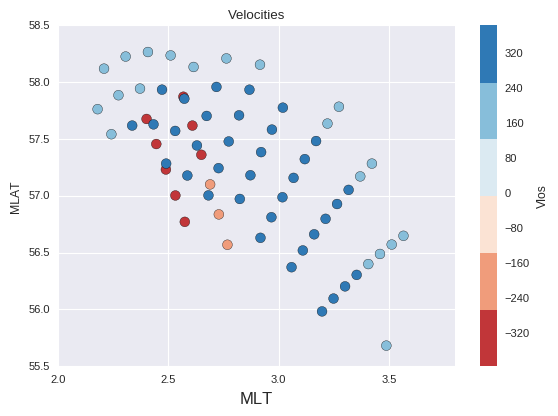

In [15]:
# Plot the velocities
# Seaborn styling
sns.set_style("darkgrid")
sns.set_context("paper")
seaMap = ListedColormap(sns.color_palette("RdBu"))
# Plot using matplotlib
fig1 = plt.figure()
ax = fig1.add_subplot(111)
velAnlysDF[ velAnlysDF["radCode"].isin(["bks", "fhe"]) ].plot( kind='scatter',
              x='normMLT_x',
              y='MLAT',
              c='Vlos',
              s=50., cmap=seaMap, ax=ax)
ax.set_ylabel("MLAT")
ax.set_xlabel("MLT", fontsize=12)
ax.set_title( "Velocities" )
# ax.set_ylim( [55., 62.] )

ax.get_figure().savefig("../figs/rawVels.pdf",bbox_inches='tight')

In [ ]:
velAnlysDF[ velAnlysDF["radCode"] == "cve" ].plot( x="azim", y="Vlos", kind="scatter" )